In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from general.nist import mass_atten
from general.spectrum_modeling import (
                                       tube_spekcalc as import_tube,
                                       xcom,
                                       xcom_reshape,
                                       density_KIinH2O,
                                       beer_lambert,
                                       visible_light,
                                       beer_lambert_unknown as bl_unk
                                       )


prj_fld = '/mnt/r/X-ray Tomography/Spectra Model/'
inp_fld = '{0}/ScriptData'.format(prj_fld)

In [2]:
# Load XOP spectra and XCOM inputs
spectrum = import_tube('{0}/80kVp 12deg.spec'.format(inp_fld))

# Get energy axis
energy = spectrum['Energy']

# Load NIST XCOM attenuation curves
air_atten = mass_atten(['Air'], xcom=1, keV=80)
Be_atten = mass_atten(['Be'], xcom=1, keV=80)
scint_atten = mass_atten(['CsI'], xcom=1, col=3, keV=80)

# Reshape XCOM x-axis to match XOP
air_atten = xcom_reshape(air_atten, energy)
Be_atten = xcom_reshape(Be_atten, energy)
scint_atten = xcom_reshape(scint_atten, energy)

# Attenuation coefficient in cm^2/g, convert to mm^2/g
air_atten['Attenuation'] *= 100
Be_atten['Attenuation'] *= 100
scint_atten['Attenuation'] *= 100

# Density in g/mm^3
air_den = 1.275E-6
Be_den = 0.00185

# CsI: Data from Saint-Gobain
scint_den =  0.00451

# Experimental setup
# Units in mm
air_epl = 340

# From RAD-60 documentation, HVL: 0.5 mm Al @ 75 kV
# Al @ 75 kV: Tot. atten. w/o coh. sc. = 0.1917 cm^2/g
# Al density = 2.7 g/cm^3
# Al rho*alpha*L = 0.51759 1/cm * 0.05 cm = 0.0258795
# Be @ 75 kV: Tot. atten. w/o coh. sc. = 0.1389 cm^2/g
# Be density = 1.85 g/cm^3
# Be rho*alpha = 0.256965 1/cm
# Be L = 0.0258975 / (0.256965 1/cm) = 0.1008 cm = 1 mm
Be_epl = 1
scint_epl = 0.15

# Scintillator response function
scint_trans = beer_lambert(
                           incident=spectrum['Intensity'],
                           attenuation=scint_atten['Attenuation'],
                           density=scint_den,
                           epl=scint_epl
                           )

# Find the detected visible light emission from the scintillator
det = visible_light(spectrum['Intensity'], scint_trans)

# Find the scintillator response
scint_resp = det / spectrum['Intensity']

# Filter the spectra through air & Be window
spectrum_filtered = beer_lambert(
                                 incident=spectrum['Intensity'],
                                 attenuation=air_atten['Attenuation'],
                                 density=air_den,
                                 epl=air_epl
                                 )

spectrum_filtered = beer_lambert(
                                 incident=spectrum_filtered,
                                 attenuation=Be_atten['Attenuation'],
                                 density=Be_den,
                                 epl=Be_epl
                                 )

# Get the detected flat field spectrum
flat_det = spectrum_filtered * scint_resp

In [3]:
# Spectra model
model = ['Water', '50p0_KI']
atten_coeff = len(model) * [None]
Transmission = len(model) * [None]

for i, m in enumerate(model):
    if m == 'Water':
        liq_atten = mass_atten(['H2O'], xcom=1, keV=80)
    else:
        liq_atten = mass_atten(['H2O', 'KI'], comp=[50, 50], xcom=1, keV=80)

    liq_atten = xcom_reshape(liq_atten, energy)
    liq_atten['Attenuation'] *= 100
    
    spray_epl = np.linspace(0, 10, 1000)

    if m == 'Water':
        spray_den = 0.001                           # KI 0%
    else:
        spray_den = density_KIinH2O(50) / 1000      # KI 50%

    # Detected spray spectrum
    spray_det = bl_unk(
                       incident=flat_det,
                       attenuation=liq_atten['Attenuation'],
                       density=spray_den,
                       epl=spray_epl
                       )
    
    # Crop out last data points (NaN)
    spray_det = [x[:-1] for x in spray_det]

    # Calculate transmission I/I0
    Transmission[i] = np.trapz(y=spray_det, x=energy[:-1]) /\
                   np.trapz(y=flat_det[:-1], x=energy[:-1])

    # Cubic spline fitting of Transmission vs. spray_epl curves 
    # (needs to be reversed b/c of monotonically increasing
    # restriction on 'x', however this does not change the interpolation call)
    cs = CubicSpline(Transmission[i][::-1], spray_epl[::-1])

    f = open(inp_fld + m + '_model.pckl', 'wb')
    pickle.dump([cs, spray_epl, Transmission[i]], f)
    f.close()

    # Overall experimental attenuation coefficient in 1/mm
    atten_coeff[i] = -np.log(Transmission[i])/spray_epl

/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


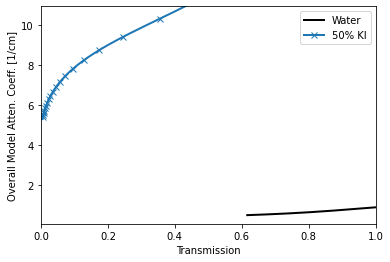

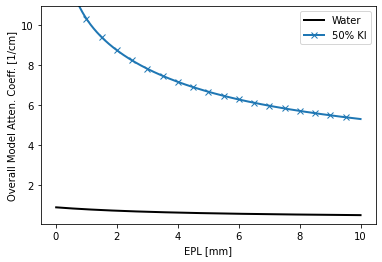

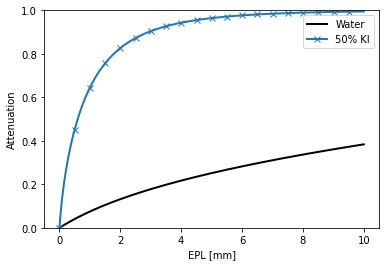

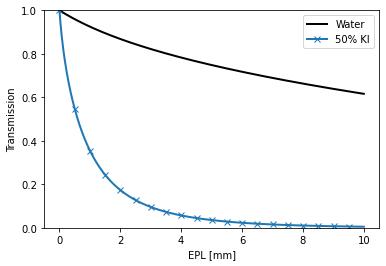

In [4]:
# Plot
plt.figure()
plt.plot(
         Transmission[0],
         atten_coeff[0]*10,
         color='k',
         linewidth=2.0,
         label='Water'
         )
plt.plot(
         Transmission[1],
         atten_coeff[1]*10,
         marker='x',
         markevery=50,
         linewidth=2.0,
         label='50% KI'
         )
plt.legend()
plt.ylabel('Overall Model Atten. Coeff. [1/cm]')
plt.xlabel('Transmission')
#plt.yscale('log')
plt.ylim([0.05, 10.95])
plt.xlim([0, 1])
plt.savefig(prj_fld + '/Figures/coeff_vs_trans.png')

plt.figure()
plt.plot(
         np.array(spray_epl),
         atten_coeff[0]*10,
         color='k',
         linewidth=2.0,
         label='Water'
         )
plt.plot(
         np.array(spray_epl),
         atten_coeff[1]*10,
         marker='x',
         markevery=50,
         linewidth=2.0,
         label='50% KI'
         )
plt.legend()
plt.ylabel('Overall Model Atten. Coeff. [1/cm]')
plt.xlabel('EPL [mm]')
#plt.yscale('log')
plt.ylim([0.05, 10.95])
plt.savefig(prj_fld + '/Figures/coeff_vs_epl.png')

plt.figure()
plt.plot(
         np.array(spray_epl),
         1-np.array(Transmission[0]),
         color='k',
         linewidth=2.0,
         label='Water'
         )
plt.plot(
         np.array(spray_epl),
         1-np.array(Transmission[1]),
         marker='x',
         markevery=50,
         linewidth=2.0,
         label='50% KI'
         )
plt.legend()
plt.ylabel('Attenuation')
plt.xlabel('EPL [mm]')
plt.ylim([0, 1])
plt.savefig(prj_fld + '/Figures/atten_vs_epl.png')

plt.figure()
plt.plot(
         np.array(spray_epl),
         np.array(Transmission[0]),
         color='k',
         linewidth=2.0,
         label='Water'
         )
plt.plot(
         np.array(spray_epl),
         np.array(Transmission[1]),
         marker='x',
         markevery=50,
         linewidth=2.0,
         label='50% KI'
         )
plt.legend()
plt.ylabel('Transmission')
plt.xlabel('EPL [mm]')
plt.ylim([0, 1])
plt.savefig(prj_fld + '/Figures/trans_vs_epl.png')